**Predicting House Prices with a Feedforward Neural Network**

*Importing the dataset*: California Housing dataset available in the library sklearn

In [86]:
# pip install scikit-learn
# pip install torch torchvision torchaudio
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# Loading the dataset
data = fetch_california_housing()
X = data.data  # Features (median income, number of rooms, etc.)
y = data.target  # Target variable (house prices)

In [87]:
# Set random seed for reproducibility
torch.manual_seed(42)

*Exploring the dataset*

In [88]:
# Convert X and y to pandas DataFrame/Series
X_df = pd.DataFrame(X, columns=data.feature_names)
y_df = pd.Series(y, name="Target")

# Display the first few rows
print(X_df.head())
print(y_df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Target, dtype: float64


In [89]:
# Summary statistics of the features
print(X_df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

In [90]:
# Check for missing values
print("Missing Values:\n", X_df.isnull().sum())


Missing Values:
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


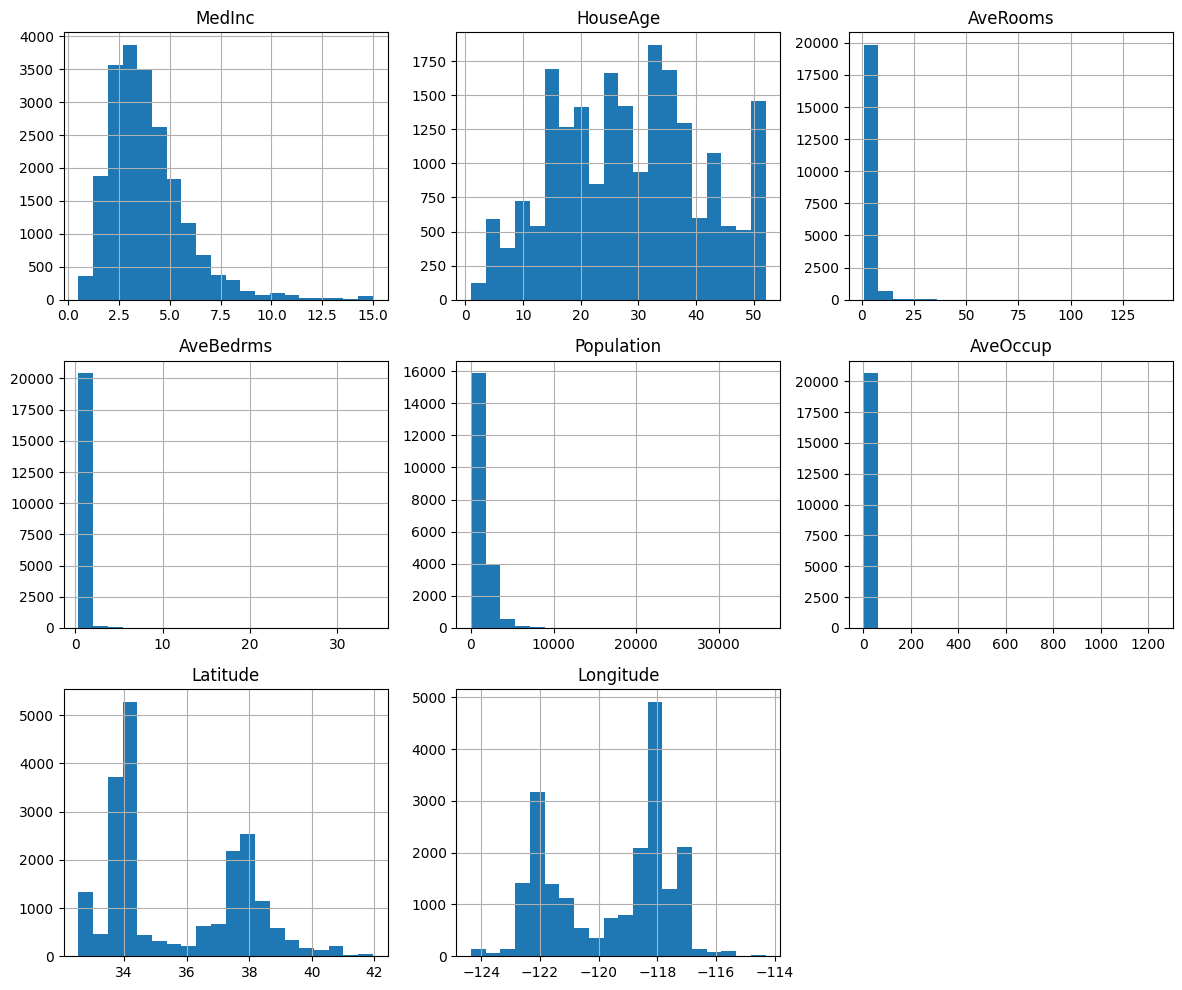

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for all features
X_df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()


In [92]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)


Training Features Shape: (16512, 8)
Testing Features Shape: (4128, 8)
Training Target Shape: (16512,)
Testing Target Shape: (4128,)


*Defining the Neural Network*

In [93]:
# Define the Feedforward Neural Network
class HousePriceNN(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNN, self).__init__()
        # Input layer to first hidden layer (64 neurons)
        self.hidden1 = nn.Linear(input_dim, 64, bias=True)
        # First hidden layer to second hidden layer (32 neurons)
        self.hidden2 = nn.Linear(64, 32, bias=True)
        # Second hidden layer to output layer (1 neuron)
        self.output = nn.Linear(32, 1, bias=True)
    
    def forward(self, x):
        # Apply ReLU activation for the hidden layers
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        # No activation for the output layer
        x = self.output(x)
        return x


*Preparing the data*

In [94]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Add a dimension for PyTorch
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

*Model architecture*

In [95]:
# Instantiate the neural network
input_dim = X_train_tensor.shape[1]  # Number of input features
model = HousePriceNN(input_dim)

# Print the model architecture
print("Model Architecture:")
print(model)

Model Architecture:
HousePriceNN(
  (hidden1): Linear(in_features=8, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


*Defining the loss and optimizer*

In [96]:
# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01)

*Train the model*

In [97]:
# Hyperparameters
epochs = 50  # Number of training epochs
learning_rate = 0.001  # Learning rate

# List to store loss values for visualization
epoch_losses = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backpropagation
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights

    # Store the loss for this epoch
    epoch_losses.append(loss.item())
    
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 3.3670
Epoch [20/50], Loss: 1.3862
Epoch [30/50], Loss: 0.9606
Epoch [40/50], Loss: 0.8302
Epoch [50/50], Loss: 0.7603


*Loss curve*

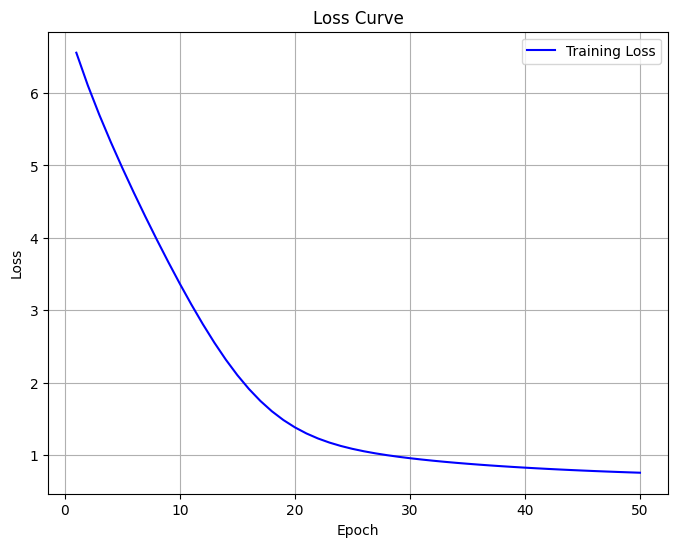

In [98]:
# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), epoch_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

*Evaluating the model on the test data*

In [99]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f"Test Loss (MSE): {test_loss.item():.4f}")
    


Test Loss (MSE): 0.7572


*Predicted vs. Actual*

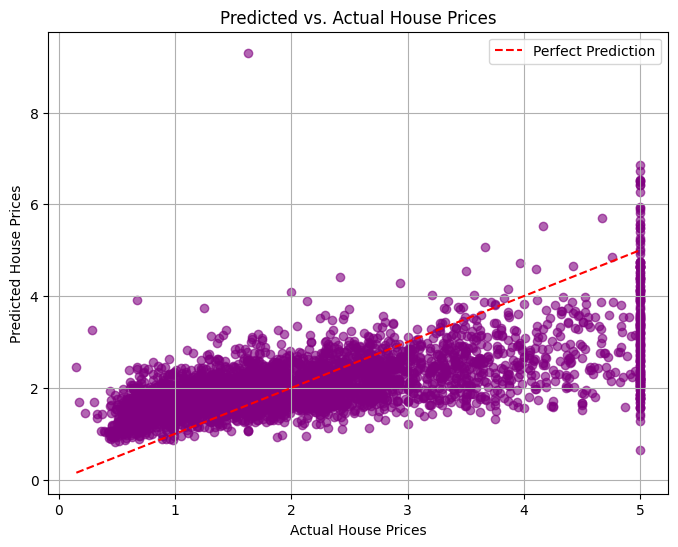

In [100]:
# Flatten the tensors for plotting (remove extra dimensions if necessary)
predicted = test_outputs.squeeze().numpy()
actual = y_test_tensor.squeeze().numpy()

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.6, color='purple')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Predicted vs. Actual House Prices')
plt.legend()
plt.grid(True)
plt.savefig('predicted_vs_actual.png') 
plt.show()